### Multivariate Time Series Forecasting - Long Short-Term Memory (LSTM)

The fundamental understanding and inspiration for Multivariate Time Series Forecasting (LSTM) implementation was taken from [1].

### Importing Libraries

In [1]:
# Importing TensorFlow library
import tensorflow as tf

# Importing the os module for interacting with the operating system
import os

# Importing pandas library for data manipulation and analysis
import pandas as pd

# Importing numpy library for numerical computations
import numpy as np

# Importing matplotlib library for creating visualizations
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Global Variables

In [2]:
# Setting the length of the sequences to be used for training the model
sequence_length = 7

# Setting the learning rate for the optimizer
learning_rate = 0.0001

# Setting the number of epochs for training the model
no_of_epochs = 90

# Setting the total battery capacity (kWh)
total_battery_capacity = 325

### Data Import

In [3]:
# Reading a CSV file into a pandas DataFrame
# The file is located at the specified path, and the first 3 rows are skipped
df = pd.read_csv(r"C:\Users\DELL 7490\Downloads\Data\july 2023 to may 2024.csv", skiprows=3)

# Displaying the first 3 rows of the DataFrame to get a quick overview of the data
df.head(3)

,Time (UTC);ACC001.Charging;ACC001.CommonAlarm;ACC001.Connected;ACC001.EnergyMeter;ACC001.Power;ACC002.Charging;ACC002.CommonAlarm;ACC002.Connected;ACC002.EnergyMeter;ACC002.Power;ACMeter.Total active power;ACMeter.TotalImport;ACMeter.TotalExport;API - NordPoolPrice;API - OutsideTemperature;BATT1.Power;BATT1.RemainingChargeCapacity;BATT1.RemainingDischargeCapacity;BATT1.StateOfCharge;CMD.BatteryRecomendation;CMD.EvDcChargingRecomendation;CMD.Watchdog;Counter;EV1.AlarmCommon;EV1.AlarmEccSlacFault;EV1.AlarmEmergencyStop;EV1.Charging;EV1.CyclicPower;EV1.EnergyMeter;EV1.StateOfCharge;EV2.AlarmCommon;EV2.AlarmEccSlacFault;EV2.AlarmEmergencyStop;EV2.Charging;EV2.CyclicPower;EV2.EnergyMeter;EV2.StateOfCharge;EV2.Power;EV1.Power;EV3.AlarmEccSlacFault;EV3.AlarmEmergencyStop;EV3.Charging;EV3.CommonAlarm;EV3.CyclicPower;EV3.EnergyMeter;EV3.Power;EV3.StateOfCharge;EV4.AlarmEccSlacFault;EV4.AlarmEmergencyStop;EV4.Charging;EV4.CommonAlarm;EV4.CyclicPower;EV4.EnergyMeter;EV4.Power;EV4.StateOfCharge;HAN001.ActivePower;HAN001.TotalExport;HAN001.TotalImport;INV001.CommonAlarm;INV001.DailyProduction;INV001.EnergyMeter;INV001.Power
0,2023-07-01T00:00:00.0000000;;;;;;;;;;;;;;;;;;;...
1,2023-07-01T00:10:00.0000000Z;;;;;;;;;;;;;;;;;;...
2,2023-07-01T00:20:00.0000000Z;;;;;;;;;;;;;;;;;;...


### Helper Functions

Comment:
    
The inspiration and understanding for the functions "generate_sequence_data" and "get_postprocessed_predictions_dataframe" was taken from [1].

In [4]:
def transform_data(dataframe):
    # Extract column names from the first row, split by semicolon
    columns = dataframe.columns.tolist()[0].split(';')
    
    # Convert dataframe values to a list and separate values by semicolon
    joined_semicolon_data = dataframe.values.tolist()
    separated_semicolon_data = []
    for lst in joined_semicolon_data:
        separated_semicolon_data.append(lst[0][:-1].split(';'))
    
    # Create a new DataFrame with the separated data and specified columns
    new_formated_df = pd.DataFrame(separated_semicolon_data, columns=columns)
    
    # Rename the 'Time (UTC)' column to 'DateTime'
    new_formated_df = new_formated_df.rename(columns={'Time (UTC)': 'DateTime'})
    
    # Convert 'DateTime' column to datetime format
    new_formated_df['DateTime'] = pd.to_datetime(new_formated_df['DateTime'])
    
    # Create a new column 'Date' by extracting the date from 'DateTime'
    new_formated_df['Date'] = new_formated_df['DateTime'].apply(lambda x: x.date())
    
    # Create a new column 'Time' by extracting the time from 'DateTime'
    new_formated_df['Time'] = new_formated_df['DateTime'].apply(lambda x: x.time())

    return new_formated_df

def filter_by_date_range(start_date, end_date, dataframe):
    # Filter the dataframe to include rows within the specified date range and reset the index
    return dataframe[(dataframe['Date'] >= start_date) & (dataframe['Date'] <= end_date)].reset_index(drop=True)

def compute_meter_differences(dataframe, old_column="EV1.EnergyMeter", new_column="Difference_EV1_EnergyMeter"):
    # Convert the specified column to float
    dataframe[[old_column]] = dataframe[[old_column]].astype(float)

    # Interpolate missing values (zero values) in the specified column
    dataframe[old_column] = dataframe[old_column].mask(dataframe[old_column] == 0).interpolate()

    # Initialize the new column with zeros
    dataframe[new_column] = 0

    # Initialize variables to track the last day and starting meter value
    last_day = None
    start_meter_value = 0

    # Iterate over each row in the dataframe
    for index, row in dataframe.iterrows():
        if index == 0:
            # Set the starting meter value for the first row
            start_meter_value = row[old_column]
            dataframe.at[index, new_column] = row[old_column] - start_meter_value
        else:
            # Calculate the difference from the starting meter value for subsequent rows
            dataframe.at[index, new_column] = row[old_column] - start_meter_value
            start_meter_value = row[old_column]
        
    return dataframe

def generate_sequence_data(df, sequence_length):
    # Initialize lists to store input (X) and output (y) sequences
    X = []
    y = []
    
    # Iterate over the dataframe to generate sequences
    for i in range(len(df) - sequence_length):
        # Extract a sequence of specified length and append to X
        X_window = df.iloc[i:i+sequence_length].values.tolist()
        X.append(X_window)
        
        # Extract the target value following the sequence and append to y
        y_row = df.iloc[i+sequence_length].values.tolist()
        y.append(y_row)
    
    return np.array(X), np.array(y)

def get_postprocessed_predictions_dataframe(dataframe, model, x_val, y_val, x_train_val):
    # Generate predictions using the model
    predictions = model.predict(x_val)
    num_of_columns = dataframe.shape[1]
    
    data = {}
    for i, column_name in zip(range(num_of_columns), dataframe.columns):
        # Extract the column data, mean, and standard deviation
        column_data = x_train_val[:, :, i]
        column_mean = np.mean(column_data)
        column_std = np.std(column_data)
        
        # Postprocess predictions and actual values
        predicts = predictions[:, i] * column_std
        predicts += column_mean
        actuals = y_val[:, i] * column_std 
        actuals += column_mean
        
        # Store postprocessed predictions and actual values in a dictionary
        data[column_name + ' Predictions'] = predicts
        data[column_name + ' Actuals'] = actuals
        
    return pd.DataFrame(data)

def calculate_battery_soc(row, consumption, source, battery_state_of_charge):
    # Declare global variables for starting SOC and total battery capacity
    global starting_value_for_BATT1_StateOfCharge_Predictions
    global total_battery_capacity
    result = 0
    
    if row[source] >= row[consumption]:
        # Calculate the battery capacity when the source is greater than or equal to consumption
        if starting_value_for_BATT1_StateOfCharge_Predictions <= 100.0:
            current_battery_capacity = starting_value_for_BATT1_StateOfCharge_Predictions * total_battery_capacity / 100
            current_battery_capacity = (current_battery_capacity + row[source]) * 100 / total_battery_capacity
        
        if current_battery_capacity < 100.0:
            result = current_battery_capacity
        else:
            starting_value_for_BATT1_StateOfCharge_Predictions = 100
            result = 100.0
    elif row[source] < row[consumption]:
        # Calculate the battery capacity when the source is less than consumption
        current_battery_capacity = starting_value_for_BATT1_StateOfCharge_Predictions * total_battery_capacity / 100
        if row[source] >= 0:
            current_battery_capacity = (current_battery_capacity - (row[consumption] - row[source])) * 100 / total_battery_capacity
      
            if current_battery_capacity <= 100 and current_battery_capacity >= 0:
                starting_value_for_BATT1_StateOfCharge_Predictions = current_battery_capacity
                result = current_battery_capacity
            else:
                starting_value_for_BATT1_StateOfCharge_Predictions = 100.0
                result = starting_value_for_BATT1_StateOfCharge_Predictions

    return result


In [5]:
# Convert the start and end dates to datetime format
start_date = pd.to_datetime('2023-9-1')
end_date = pd.to_datetime('2024-4-30')

# Transform the original DataFrame to reformat and extract necessary columns
df = transform_data(df)

# Filter the transformed DataFrame to include only the rows within the specified date range
df = filter_by_date_range(start_date, end_date, df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [6]:
# Fill missing values with '0' in the specified columns
df[['INV001.EnergyMeter', 'HAN001.TotalImport', 'ACMeter.TotalImport', 'ACMeter.TotalExport', 
    'EV1.CyclicPower', 'EV2.CyclicPower', 'EV3.CyclicPower', 'EV4.CyclicPower', 
    'INV001.DailyProduction', 'BATT1.Power', 'ACMeter.Total active power', 
    'EV1.EnergyMeter', 'EV2.EnergyMeter', 'EV3.EnergyMeter', 'EV4.EnergyMeter', 
    'API - NordPoolPrice', 'BATT1.RemainingDischargeCapacity']] = df[['INV001.EnergyMeter', 
    'HAN001.TotalImport', 'ACMeter.TotalImport', 'ACMeter.TotalExport', 'EV1.CyclicPower', 
    'EV2.CyclicPower', 'EV3.CyclicPower', 'EV4.CyclicPower', 'INV001.DailyProduction', 
    'BATT1.Power', 'ACMeter.Total active power', 'EV1.EnergyMeter', 'EV2.EnergyMeter', 
    'EV3.EnergyMeter', 'EV4.EnergyMeter', 'API - NordPoolPrice', 'BATT1.RemainingDischargeCapacity']].fillna(value='0')

# Replace empty strings with '0' in the specified columns
df[['INV001.EnergyMeter', 'HAN001.TotalImport', 'ACMeter.TotalImport', 'ACMeter.TotalExport', 
    'EV1.CyclicPower', 'EV2.CyclicPower', 'EV3.CyclicPower', 'EV4.CyclicPower', 
    'INV001.DailyProduction', 'BATT1.Power', 'ACMeter.Total active power', 
    'EV1.EnergyMeter', 'EV2.EnergyMeter', 'EV3.EnergyMeter', 'EV4.EnergyMeter', 
    'API - NordPoolPrice', 'BATT1.RemainingDischargeCapacity']] = df[['INV001.EnergyMeter', 
    'HAN001.TotalImport', 'ACMeter.TotalImport', 'ACMeter.TotalExport', 'EV1.CyclicPower', 
    'EV2.CyclicPower', 'EV3.CyclicPower', 'EV4.CyclicPower', 'INV001.DailyProduction', 
    'BATT1.Power', 'ACMeter.Total active power', 'EV1.EnergyMeter', 'EV2.EnergyMeter', 
    'EV3.EnergyMeter', 'EV4.EnergyMeter', 'API - NordPoolPrice', 'BATT1.RemainingDischargeCapacity']].replace('', '0')

# Fill missing values with 'False' in the specified columns
df[['EV1.Charging', 'EV2.Charging', 'EV3.Charging', 'EV4.Charging']] = df[['EV1.Charging', 
    'EV2.Charging', 'EV3.Charging', 'EV4.Charging']].fillna(value='False')

# Replace empty strings with 'False' in the specified columns
df[['EV1.Charging', 'EV2.Charging', 'EV3.Charging', 'EV4.Charging']] = df[['EV1.Charging', 
    'EV2.Charging', 'EV3.Charging', 'EV4.Charging']].replace('', 'False')


In [7]:
# Set the DataFrame index to be the 'DateTime' column, ensuring it is in datetime format with UTC timezone
df.index = pd.to_datetime(df['DateTime'], utc=True, format='%Y-%m-%d %H:%M:%S')

# Display the first 3 rows of the DataFrame to get a quick overview of the data with the new index
df.head(3)

,DateTime,ACC001.Charging,ACC001.CommonAlarm,ACC001.Connected,ACC001.EnergyMeter,ACC001.Power,ACC002.Charging,ACC002.CommonAlarm,ACC002.Connected,ACC002.EnergyMeter,...,EV4.StateOfCharge,HAN001.ActivePower,HAN001.TotalExport,HAN001.TotalImport,INV001.CommonAlarm,INV001.DailyProduction,INV001.EnergyMeter,INV001.Power,Date,Time
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-09-01 00:00:00+00:00,2023-09-01 00:00:00+00:00,False,False,False,19,0,False,False,False,43,...,0,169.5,0,1028315,False,0,21841.322,0,2023-09-01,00:00:00
2023-09-01 00:00:00+00:00,2023-09-01 00:00:00,False,False,False,19,0,False,False,False,43,...,0,168.5,0,1028315,False,0,21841.322,0,2023-09-01,00:00:00
2023-09-01 00:10:00+00:00,2023-09-01 00:10:00+00:00,False,False,False,19,0,False,False,False,43,...,0,169,0,1028315,True,0,21841.322,0,2023-09-01,00:10:00


In [8]:
# Get the dimensions of the DataFrame (number of rows and columns)
df.shape

(35000, 65)

In [9]:
# Initialize the index of the month of interest
month_of_interest_index = 0

# Convert the date of interest to datetime format
date_of_interest = '2024-04-01 00:00:00'
date_of_interest = pd.to_datetime(date_of_interest)

# Iterate through the DataFrame to find the index of the date of interest
for index, row in df.iterrows():
    if row['DateTime'] == date_of_interest:
        # Print the index of the date of interest and break the loop
        print(index)
        break
    month_of_interest_index += 1

# Print the index of the first occurrence of the date of interest
print("Index of the first occurrence of " + str(date_of_interest) + " :", month_of_interest_index)

2024-04-01 00:00:00+00:00
Index of the first occurrence of 2024-04-01 00:00:00 : 30680


In [10]:
# Compute differences for 'EV1.EnergyMeter' and rename columns
df = compute_meter_differences(df, old_column="EV1.EnergyMeter", new_column="EV1_EnergyMeter")

# Compute differences for 'EV2.EnergyMeter' and rename columns
df = compute_meter_differences(df, old_column="EV2.EnergyMeter", new_column="EV2_EnergyMeter")

# Compute differences for 'EV3.EnergyMeter' and rename columns
df = compute_meter_differences(df, old_column="EV3.EnergyMeter", new_column="EV3_EnergyMeter")

# Compute differences for 'EV4.EnergyMeter' and rename columns
df = compute_meter_differences(df, old_column="EV4.EnergyMeter", new_column="EV4_EnergyMeter")

# Compute differences for 'INV001.EnergyMeter' and rename columns
df = compute_meter_differences(df, old_column='INV001.EnergyMeter', new_column='INV001_EnergyMeter')

# Compute differences for 'HAN001.TotalImport' and rename columns
df = compute_meter_differences(df, old_column='HAN001.TotalImport', new_column='HAN001_TotalImport')

# Compute differences for 'ACMeter.TotalImport' and rename columns
df = compute_meter_differences(df, old_column='ACMeter.TotalImport', new_column='ACMeter_TotalImport')

# Compute differences for 'ACMeter.TotalExport' and rename columns
df = compute_meter_differences(df, old_column='ACMeter.TotalExport', new_column='ACMeter_TotalExport')

# Compute differences for 'BATT1.RemainingDischargeCapacity' and rename columns
df = compute_meter_differences(df, old_column='BATT1.RemainingDischargeCapacity', new_column='BATT1_RemainingDischargeCapacity')

# Convert 'BATT1.StateOfCharge' column to float type
df[["BATT1.StateOfCharge"]] = df[["BATT1.StateOfCharge"]].astype(float)


<AxesSubplot:xlabel='DateTime'>

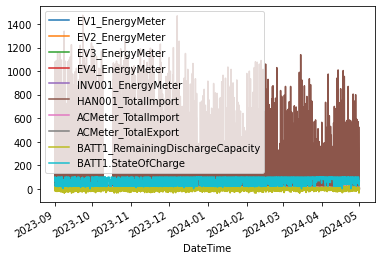

In [11]:
# Selecting specific columns from the DataFrame
df = df[['EV1_EnergyMeter', 'EV2_EnergyMeter', 'EV3_EnergyMeter', 'EV4_EnergyMeter', 
         'INV001_EnergyMeter', 'HAN001_TotalImport', 'ACMeter_TotalImport', 'ACMeter_TotalExport', 
         'BATT1_RemainingDischargeCapacity', 'BATT1.StateOfCharge']]

# Plotting the selected columns
df.plot()

In [12]:
# Generating sequences (X_val, y_val) from the DataFrame using a specified sequence length
x_val, y_val = generate_sequence_data(df, sequence_length)

In [13]:
# Get the total number of rows in x_val (assuming x_val is already defined)
total_rows_df = x_val.shape[0]

# Define the start index for the test set based on the month of interest index and sequence length
test_value_start = month_of_interest_index - sequence_length

# Split the sequences into train, validation, and test sets
# Training set (x_train_val, y_train_val) from the beginning to index 22038
x_train_val, y_train_val = x_val[:22038], y_val[:22038]

# Validation set (x_val_val, y_val_val) from index 22038 to test_value_start (exclusive)
x_val_val, y_val_val = x_val[22038:test_value_start], y_val[22038:test_value_start]

# Test set (x_test_val, y_test_val) from test_value_start to the end of the sequences
x_test_val, y_test_val = x_val[test_value_start:], y_val[test_value_start:]

In [14]:
# Create a copy of x_train_val and assign it to x_train_modified
x_train_modified = x_train_val.copy()

# Create another copy of x_train_val and assign it to x_train_value_save
x_train_value_save = x_train_val.copy()

Comment:

The inspiration and understanding for the functions "normalize_input_using_training_stats" and "normalize_output_using_training_stats" was taken from [1].

In [15]:
def normalize_input_using_training_stats(dataframe, train_val, x_values):
    """
    Normalize input data (x_values) using training statistics (mean and standard deviation).

    Args:
    - dataframe: Original dataframe containing the data.
    - train_val: Training data used for normalization statistics.
    - x_values: Input data to be normalized.

    Returns:
    - Normalized x_values based on training statistics.
    """
    num_of_columns = dataframe.shape[1]
    
    # Normalize each column of x_values using mean and standard deviation from train_val
    for i in range(num_of_columns):
        column_data = train_val[:, :, i]
        column_mean = np.mean(column_data)
        column_std = np.std(column_data)
        
        X_column_data = x_values[:, :, i]
        x_values[:, :, i] = (X_column_data - column_mean) / column_std

    return x_values

def normalize_output_using_training_stats(dataframe, train_val, y_values):
    """
    Normalize output data (y_values) using training statistics (mean and standard deviation).

    Args:
    - dataframe: Original dataframe containing the data.
    - train_val: Training data used for normalization statistics.
    - y_values: Output data to be normalized.

    Returns:
    - Normalized y_values based on training statistics.
    """
    num_of_columns = dataframe.shape[1]
    
    # Normalize each column of y_values using mean and standard deviation from train_val
    for i in range(num_of_columns):
        column_data = train_val[:, :, i]
        column_mean = np.mean(column_data)
        column_std = np.std(column_data)
      
        y_column_data = y_values[:, i]
        y_values[:, i] = (y_column_data - column_mean) / column_std

    return y_values


In [16]:
# Normalize input data x_train_modified using training statistics from x_train_val
normalize_input_using_training_stats(df, x_train_val, x_train_modified)

# Normalize input data x_val_val using training statistics from x_train_val
normalize_input_using_training_stats(df, x_train_val, x_val_val)

# Normalize input data x_test_val using training statistics from x_train_val
normalize_input_using_training_stats(df, x_train_val, x_test_val)

# Normalize output data y_train_val using training statistics from x_train_val
normalize_output_using_training_stats(df, x_train_val, y_train_val)

# Normalize output data y_val_val using training statistics from x_train_val
normalize_output_using_training_stats(df, x_train_val, y_val_val)

# Normalize output data y_test_val using training statistics from x_train_val
normalize_output_using_training_stats(df, x_train_val, y_test_val)

# Make a copy of x_train_modified and assign it back to x_train_val
x_train_val = x_train_modified.copy()

In [17]:
# Set the random seed for reproducibility
tf.keras.utils.set_random_seed(42)

# Define a sequential model in TensorFlow Keras
model = tf.keras.Sequential([
    # Input layer expecting input of shape (sequence_length, 10)
    tf.keras.layers.InputLayer((sequence_length, 10)),
    
    # LSTM layer with 64 units
    tf.keras.layers.LSTM(64),
    
    # Dense layer with 8 units and ReLU activation function
    tf.keras.layers.Dense(8, activation='relu'),
    
    # Output layer with 10 units and linear activation function
    tf.keras.layers.Dense(10, activation='linear')
])


In [18]:
# Callback to save the model with the best validation loss during training
model_check_points = tf.keras.callbacks.ModelCheckpoint('model_save.keras', save_best_only=True)

# Compile the model with Mean Squared Error loss, Adam optimizer with specified learning rate, and Root Mean Squared Error metric
model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model using training data (x_train_val, y_train_val) and validate on validation data (x_val_val, y_val_val)
# Perform training for specified number of epochs (no_of_epochs) and use model checkpoint callback for saving the best model
model.fit(x_train_val, y_train_val, 
          validation_data=(x_val_val, y_val_val), 
          epochs=no_of_epochs, 
          callbacks=[model_check_points])


Epoch 1/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.9797 - root_mean_squared_error: 0.9893 - val_loss: 0.6522 - val_root_mean_squared_error: 0.8077
Epoch 2/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.8034 - root_mean_squared_error: 0.8959 - val_loss: 0.5442 - val_root_mean_squared_error: 0.7378
Epoch 3/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6942 - root_mean_squared_error: 0.8327 - val_loss: 0.4670 - val_root_mean_squared_error: 0.6834
Epoch 4/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.6136 - root_mean_squared_error: 0.7827 - val_loss: 0.4209 - val_root_mean_squared_error: 0.6488
Epoch 5/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.5644 - root_mean_squared_error: 0.7506 - val_loss: 0.3939 - val_root_mean_squared_error: 0.6277
Epoch 6/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.5333 - root_mean_squared_error: 0.7295 - val_loss: 0.3767 - val_root_mean_squared_error: 0.6139
Epoch 7/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10

689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.4072 - root_mean_squared_error: 0.6370 - val_loss: 0.2918 - val_root_mean_squared_error: 0.5403
Epoch 44/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.4057 - root_mean_squared_error: 0.6359 - val_loss: 0.2911 - val_root_mean_squared_error: 0.5396
Epoch 45/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.4042 - root_mean_squared_error: 0.6347 - val_loss: 0.2904 - val_root_mean_squared_error: 0.5390
Epoch 46/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.4028 - root_mean_squared_error: 0.6336 - val_loss: 0.2897 - val_root_mean_squared_error: 0.5384
Epoch 47/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.4015 - root_mean_squared_error: 0.6325 - val_loss: 0.2892 - val_root_mean_squared_error: 0.5379
Epoch 48/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.4002 - root_mean_squared_error: 0.6315 - val_loss: 0.2889 - val_root_mean_squared_error: 0.5376
Epoch 49/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3751 - root_mean_squared_error: 0.6113 - val_loss: 0.2825 - val_root_mean_squared_error: 0.5315
Epoch 86/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3747 - root_mean_squared_error: 0.6109 - val_loss: 0.2827 - val_root_mean_squared_error: 0.5318
Epoch 87/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3743 - root_mean_squared_error: 0.6106 - val_loss: 0.2831 - val_root_mean_squared_error: 0.5321
Epoch 88/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.3738 - root_mean_squared_error: 0.6103 - val_loss: 0.2831 - val_root_mean_squared_error: 0.5322
Epoch 89/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3735 - root_mean_squared_error: 0.6100 - val_loss: 0.2832 - val_root_mean_squared_error: 0.5323
Epoch 90/90
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3731 - root_mean_squared_error: 0.6097 - val_loss: 0.2829 - val_root_mean_squared_error: 0.5320


In [19]:
# Generate a DataFrame with post-processed predictions using the trained model
post_processed_dataframe = get_postprocessed_predictions_dataframe(df, model, x_test_val, y_test_val, x_train_value_save)

# Display the first 3 rows of the post-processed DataFrame
post_processed_dataframe.head(3)

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,EV1_EnergyMeter Predictions,EV1_EnergyMeter Actuals,EV2_EnergyMeter Predictions,EV2_EnergyMeter Actuals,EV3_EnergyMeter Predictions,EV3_EnergyMeter Actuals,EV4_EnergyMeter Predictions,EV4_EnergyMeter Actuals,INV001_EnergyMeter Predictions,INV001_EnergyMeter Actuals,HAN001_TotalImport Predictions,HAN001_TotalImport Actuals,ACMeter_TotalImport Predictions,ACMeter_TotalImport Actuals,ACMeter_TotalExport Predictions,ACMeter_TotalExport Actuals,BATT1_RemainingDischargeCapacity Predictions,BATT1_RemainingDischargeCapacity Actuals,BATT1.StateOfCharge Predictions,BATT1.StateOfCharge Actuals
0,-0.012125,0.0,0.119341,0.0,0.362070,0.0,0.630599,0.0,-0.002205,0.0,19.167545,0.0,12.667714,13.00,-0.001339,-3.469447e-18,10.469877,10.0,82.204124,81.3
1,0.078522,0.0,0.089435,0.0,0.176214,0.0,0.418333,0.0,-0.002368,0.0,20.084160,0.0,12.285908,12.98,-0.000242,-3.469447e-18,10.470802,11.0,84.403244,84.7
2,0.092901,0.0,0.063689,0.0,0.138505,0.0,0.479306,0.0,-0.000750,0.0,21.805153,0.0,11.644905,12.94,0.000327,-3.469447e-18,9.861475,11.0,87.389465,88.0


In [20]:
# Add a new column "DateTime" to the post-processed DataFrame, using indices from original dataframe df
post_processed_dataframe["DateTime"] = df.iloc[test_value_start + sequence_length:].index

# Display the first 3 rows of the post-processed DataFrame with the new "DateTime" column
post_processed_dataframe.head(3)

,EV1_EnergyMeter Predictions,EV1_EnergyMeter Actuals,EV2_EnergyMeter Predictions,EV2_EnergyMeter Actuals,EV3_EnergyMeter Predictions,EV3_EnergyMeter Actuals,EV4_EnergyMeter Predictions,EV4_EnergyMeter Actuals,INV001_EnergyMeter Predictions,INV001_EnergyMeter Actuals,...,HAN001_TotalImport Actuals,ACMeter_TotalImport Predictions,ACMeter_TotalImport Actuals,ACMeter_TotalExport Predictions,ACMeter_TotalExport Actuals,BATT1_RemainingDischargeCapacity Predictions,BATT1_RemainingDischargeCapacity Actuals,BATT1.StateOfCharge Predictions,BATT1.StateOfCharge Actuals,DateTime
0,-0.012125,0.0,0.119341,0.0,0.362070,0.0,0.630599,0.0,-0.002205,0.0,...,0.0,12.667714,13.00,-0.001339,-3.469447e-18,10.469877,10.0,82.204124,81.3,2024-04-01 00:00:00+00:00
1,0.078522,0.0,0.089435,0.0,0.176214,0.0,0.418333,0.0,-0.002368,0.0,...,0.0,12.285908,12.98,-0.000242,-3.469447e-18,10.470802,11.0,84.403244,84.7,2024-04-01 00:10:00+00:00
2,0.092901,0.0,0.063689,0.0,0.138505,0.0,0.479306,0.0,-0.000750,0.0,...,0.0,11.644905,12.94,0.000327,-3.469447e-18,9.861475,11.0,87.389465,88.0,2024-04-01 00:20:00+00:00


In [21]:
# Remove the 'DateTime' column from post_processed_dataframe and store it in a variable named DateTime
DateTime = post_processed_dataframe.pop('DateTime')

# Insert the 'DateTime' column back into post_processed_dataframe at the first position
post_processed_dataframe.insert(0, 'DateTime', DateTime)

# Convert the 'DateTime' column to string format
post_processed_dataframe['DateTime'] = post_processed_dataframe['DateTime'].astype(str)

### Predictions

In [22]:
print("\033[1mEnergy Summary over the period\033[0m")

print("\n\033[1mBuilding\033[0m")
import_from_grid=post_processed_dataframe['HAN001_TotalImport Predictions'].sum()
import_from_building = post_processed_dataframe['ACMeter_TotalImport Predictions'].sum()
export_to_building = post_processed_dataframe['ACMeter_TotalExport Predictions'].sum()
net_import_from_buidling=import_from_building-export_to_building
consume_tenants_and_technical=import_from_grid-import_from_building

print("Import from grid :\t\t\t",round(import_from_grid,2),"kWh")
print("Net export to Powerpal :\t\t",round(net_import_from_buidling,2),"kWh")
print("Consume_tenants_and_technical :\t\t",round(consume_tenants_and_technical,2),"kWh")

print("\n\033[1mPowerpal\033[0m")

solar_power = post_processed_dataframe['INV001_EnergyMeter Predictions'].sum()
EV1_EnergyMeter = post_processed_dataframe['EV1_EnergyMeter Predictions'].sum()
EV2_EnergyMeter = post_processed_dataframe['EV2_EnergyMeter Predictions'].sum()
EV3_EnergyMeter = post_processed_dataframe['EV3_EnergyMeter Predictions'].sum()
EV4_EnergyMeter = post_processed_dataframe['EV4_EnergyMeter Predictions'].sum()
EV_fast_charging_DC=EV1_EnergyMeter+EV2_EnergyMeter+EV3_EnergyMeter+EV4_EnergyMeter
BATT1_RemainingDischargeCapacity=post_processed_dataframe['BATT1_RemainingDischargeCapacity Predictions'].sum()

total_source_powerpal=net_import_from_buidling+solar_power
internal_usage_loss=total_source_powerpal-EV_fast_charging_DC+BATT1_RemainingDischargeCapacity
consume=EV_fast_charging_DC+internal_usage_loss+BATT1_RemainingDischargeCapacity
percentage_loss=internal_usage_loss*100.0/consume
                                
print("Import from building :\t\t\t",round(import_from_building,2),"kWh")
print("Export to building (Solar PV / ESS) :\t",round(export_to_building,2),"kWh")
print("Net import from building:\t\t",round(net_import_from_buidling,2),"kWh")
print("Solar PV Production :\t\t\t",round(solar_power,2),"kWh")
print("Consume (EV charging + internal) :\t",round(consume,2),"kWh")
print("EV fast charging DC :\t\t\t",round(EV_fast_charging_DC,2),"kWh")
print("EV normal charging AC :\t\t\t\t")
print("Internal usage/loss :\t\t\t",round(internal_usage_loss,2),"kWh","\t",round(percentage_loss,2),"%")


Energy Summary over the period

Building
Import from grid :			 172822.31 kWh
Net export to Powerpal :		 9112.83 kWh
Consume_tenants_and_technical :		 162525.22 kWh

Powerpal
Import from building :			 10297.09 kWh
Export to building (Solar PV / ESS) :	 1184.26 kWh
Net import from building:		 9112.83 kWh
Solar PV Production :			 3415.7 kWh
Consume (EV charging + internal) :	 6994.27 kWh
EV fast charging DC :			 12072.82 kWh
EV normal charging AC :				
Internal usage/loss :			 -2311.42 kWh 	 -33.05 %


### Actuals

In [23]:
print("\033[1mEnergy Summary over the period\033[0m")

print("\n\033[1mBuilding\033[0m")
import_from_grid=post_processed_dataframe['HAN001_TotalImport Actuals'].sum()
import_from_building = post_processed_dataframe['ACMeter_TotalImport Actuals'].sum()
export_to_building = post_processed_dataframe['ACMeter_TotalExport Actuals'].sum()
net_import_from_buidling=import_from_building-export_to_building
consume_tenants_and_technical=import_from_grid-import_from_building

print("Import from grid :\t\t\t",round(import_from_grid,2),"kWh")
print("Net export to Powerpal :\t\t",round(net_import_from_buidling,2),"kWh")
print("Consume_tenants_and_technical :\t\t",round(consume_tenants_and_technical,2),"kWh")

print("\n\033[1mPowerpal\033[0m")

solar_power =post_processed_dataframe['INV001_EnergyMeter Actuals'].sum()
EV1_EnergyMeter =post_processed_dataframe['EV1_EnergyMeter Actuals'].sum()
EV2_EnergyMeter = post_processed_dataframe['EV2_EnergyMeter Actuals'].sum()
EV3_EnergyMeter = post_processed_dataframe['EV3_EnergyMeter Actuals'].sum()
EV4_EnergyMeter = post_processed_dataframe['EV4_EnergyMeter Actuals'].sum()
EV_fast_charging_DC=EV1_EnergyMeter+EV2_EnergyMeter+EV3_EnergyMeter+EV4_EnergyMeter
BATT1_RemainingDischargeCapacity=post_processed_dataframe['BATT1_RemainingDischargeCapacity Actuals'].sum()

total_source_powerpal=net_import_from_buidling+solar_power
internal_usage_loss=total_source_powerpal-EV_fast_charging_DC+BATT1_RemainingDischargeCapacity
consume=EV_fast_charging_DC+internal_usage_loss+BATT1_RemainingDischargeCapacity
percentage_loss=internal_usage_loss*100.0/consume

print("Import from building :\t\t\t",round(import_from_building,2),"kWh")
print("Export to building (Solar PV / ESS) :\t",round(export_to_building,2),"kWh")
print("Net import from building:\t\t",round(net_import_from_buidling,2),"kWh")
print("Solar PV Production :\t\t\t",round(solar_power,2),"kWh")
print("Consume (EV charging + internal) :\t",round(consume,2),"kWh")
print("EV fast charging DC :\t\t\t",round(EV_fast_charging_DC,2),"kWh")
print("EV normal charging AC :\t\t\t\t")
print("Internal usage/loss :\t\t\t",round(internal_usage_loss,2),"kWh","\t",round(percentage_loss,2),"%")


Energy Summary over the period

Building
Import from grid :			 126610.0 kWh
Net export to Powerpal :		 10355.6 kWh
Consume_tenants_and_technical :		 114647.31 kWh

Powerpal
Import from building :			 11962.69 kWh
Export to building (Solar PV / ESS) :	 1607.09 kWh
Net import from building:		 10355.6 kWh
Solar PV Production :			 2986.1 kWh
Consume (EV charging + internal) :	 13255.7 kWh
EV fast charging DC :			 10178.05 kWh
EV normal charging AC :				
Internal usage/loss :			 3120.65 kWh 	 23.54 %


### Predicting Battery Usage

In [24]:
# Define columns to sum for EVs consumption predictions
columns_to_sum = ['EV1_EnergyMeter Predictions', 'EV2_EnergyMeter Predictions', 'EV3_EnergyMeter Predictions', 'EV4_EnergyMeter Predictions']

# Calculate total consumption predictions for EVs and add a new column to the DataFrame
post_processed_dataframe['EVs Consumption Predictions'] = post_processed_dataframe[columns_to_sum].sum(axis=1)

# Calculate tenants' consumption predictions by subtracting imports and exports from the building and add a new column
post_processed_dataframe['Tenants Consumption Predictions'] = post_processed_dataframe['HAN001_TotalImport Predictions'] - post_processed_dataframe['ACMeter_TotalImport Predictions'] - post_processed_dataframe['ACMeter_TotalExport Predictions']

# Calculate total consumption by summing EVs and tenants' consumption predictions and add a new column
post_processed_dataframe['Total Consumption'] = post_processed_dataframe['EVs Consumption Predictions'] + post_processed_dataframe['Tenants Consumption Predictions']

# Calculate total source power from the grid and solar by adding imports and subtracting exports and add a new column
post_processed_dataframe['Total Source Power Grid & Solar'] = post_processed_dataframe['ACMeter_TotalImport Predictions'] - post_processed_dataframe['ACMeter_TotalExport Predictions'] + post_processed_dataframe['HAN001_TotalImport Predictions']

In [25]:
post_processed_dataframe.head(3)

,DateTime,EV1_EnergyMeter Predictions,EV1_EnergyMeter Actuals,EV2_EnergyMeter Predictions,EV2_EnergyMeter Actuals,EV3_EnergyMeter Predictions,EV3_EnergyMeter Actuals,EV4_EnergyMeter Predictions,EV4_EnergyMeter Actuals,INV001_EnergyMeter Predictions,...,ACMeter_TotalExport Predictions,ACMeter_TotalExport Actuals,BATT1_RemainingDischargeCapacity Predictions,BATT1_RemainingDischargeCapacity Actuals,BATT1.StateOfCharge Predictions,BATT1.StateOfCharge Actuals,EVs Consumption Predictions,Tenants Consumption Predictions,Total Consumption,Total Source Power Grid & Solar
0,2024-04-01 00:00:00+00:00,-0.012125,0.0,0.119341,0.0,0.362070,0.0,0.630599,0.0,-0.002205,...,-0.001339,-3.469447e-18,10.469877,10.0,82.204124,81.3,1.099884,6.501170,7.601054,31.836597
1,2024-04-01 00:10:00+00:00,0.078522,0.0,0.089435,0.0,0.176214,0.0,0.418333,0.0,-0.002368,...,-0.000242,-3.469447e-18,10.470802,11.0,84.403244,84.7,0.762504,7.798494,8.560998,32.370308
2,2024-04-01 00:20:00+00:00,0.092901,0.0,0.063689,0.0,0.138505,0.0,0.479306,0.0,-0.000750,...,0.000327,-3.469447e-18,9.861475,11.0,87.389465,88.0,0.774401,10.159921,10.934321,33.449730


In [26]:
# Retrieve the initial predicted state of charge for BATT1 from the first row of predictions
starting_value_for_BATT1_StateOfCharge_Predictions = post_processed_dataframe['BATT1.StateOfCharge Predictions'].iloc[0]

# Ensure that 'Total Consumption' values are non-negative (set to zero if negative)
post_processed_dataframe['Total Consumption'] = post_processed_dataframe['Total Consumption'].apply(lambda x: max(0.0, x))

# Ensure that 'Total Source Power Grid & Solar' values are non-negative (set to zero if negative)
post_processed_dataframe['Total Source Power Grid & Solar'] = post_processed_dataframe['Total Source Power Grid & Solar'].apply(lambda x: max(0.0, x))

In [27]:
post_processed_dataframe['Battery Percentage'] = post_processed_dataframe.apply(lambda row: calculate_battery_soc(row,consumption='Total Consumption',source='Total Source Power Grid & Solar',battery_state_of_charge='BATT1.StateOfCharge Predictions'), axis=1)

post_processed_dataframe.head(3)

,DateTime,EV1_EnergyMeter Predictions,EV1_EnergyMeter Actuals,EV2_EnergyMeter Predictions,EV2_EnergyMeter Actuals,EV3_EnergyMeter Predictions,EV3_EnergyMeter Actuals,EV4_EnergyMeter Predictions,EV4_EnergyMeter Actuals,INV001_EnergyMeter Predictions,...,ACMeter_TotalExport Actuals,BATT1_RemainingDischargeCapacity Predictions,BATT1_RemainingDischargeCapacity Actuals,BATT1.StateOfCharge Predictions,BATT1.StateOfCharge Actuals,EVs Consumption Predictions,Tenants Consumption Predictions,Total Consumption,Total Source Power Grid & Solar,Battery Percentage
0,2024-04-01 00:00:00+00:00,-0.012125,0.0,0.119341,0.0,0.362070,0.0,0.630599,0.0,-0.002205,...,-3.469447e-18,10.469877,10.0,82.204124,81.3,1.099884,6.501170,7.601054,31.836597,92.000001
1,2024-04-01 00:10:00+00:00,0.078522,0.0,0.089435,0.0,0.176214,0.0,0.418333,0.0,-0.002368,...,-3.469447e-18,10.470802,11.0,84.403244,84.7,0.762504,7.798494,8.560998,32.370308,92.164219
2,2024-04-01 00:20:00+00:00,0.092901,0.0,0.063689,0.0,0.138505,0.0,0.479306,0.0,-0.000750,...,-3.469447e-18,9.861475,11.0,87.389465,88.0,0.774401,10.159921,10.934321,33.449730,92.496349


### Cost Analysis

Comment:

The imported file in the section i.e; "MultiVariate_LSTM2.xlsx" has the same dataframe as post_processed_dataframe but with one change. "API - NordPoolPrice" was manually added from original dataset (for month of April 2024) after exporting post_processed_dataframe to MultiVariate_LSTM2.xlsx. This can be confirmed by seeing the printed section of post_processed_dataframe before and after the import.

In [28]:
excel_file_path = "MultiVariate_LSTM2.xlsx"

# Read the DataFrame from excel
post_processed_dataframe = pd.read_excel(excel_file_path)

df = pd.read_csv(r"C:\Users\DELL 7490\Downloads\Data\july 2023 to may 2024.csv",skiprows=3)
post_processed_dataframe.head(3)

,DateTime,EV1_EnergyMeter Predictions,EV1_EnergyMeter Actuals,EV2_EnergyMeter Predictions,EV2_EnergyMeter Actuals,EV3_EnergyMeter Predictions,EV3_EnergyMeter Actuals,EV4_EnergyMeter Predictions,EV4_EnergyMeter Actuals,INV001_EnergyMeter Predictions,...,BATT1_RemainingDischargeCapacity Predictions,BATT1_RemainingDischargeCapacity Actuals,BATT1.StateOfCharge Predictions,BATT1.StateOfCharge Actuals,EVs Consumption Predictions,Tenants Consumption Predictions,Total Consumption,Total Source Power Grid & Solar,Battery Percentage,API - NordPoolPrice
0,2024-04-01 00:00:00+00:00,-0.012125,0.0,0.119341,0.0,0.362070,0.0,0.630599,0.0,-0.002205,...,10.469877,10.0,82.204124,81.3,1.099884,6.501170,7.601054,31.836597,92.000001,580.61
1,2024-04-01 00:10:00+00:00,0.078522,0.0,0.089435,0.0,0.176214,0.0,0.418333,0.0,-0.002368,...,10.470802,11.0,84.403244,84.7,0.762504,7.798494,8.560998,32.370308,92.164219,555.94
2,2024-04-01 00:20:00+00:00,0.092901,0.0,0.063689,0.0,0.138505,0.0,0.479306,0.0,-0.000750,...,9.861475,11.0,87.389465,88.0,0.774401,10.159921,10.934321,33.449730,92.496349,555.94


In [29]:
# Shift the 'Battery Percentage' values downwards by 1 row and store in 'shifted_values_battery_predictions'
shifted_values_battery_predictions = post_processed_dataframe['Battery Percentage'].shift(1)

# Calculate the change in battery predictions by subtracting the shifted values from the current values
post_processed_dataframe['battery_predictions_change'] = post_processed_dataframe['Battery Percentage'] - shifted_values_battery_predictions

# Shift the 'BATT1.StateOfCharge Actuals' values downwards by 1 row and store in 'shifted_values_battery_actuals'
shifted_values_battery_actuals = post_processed_dataframe['BATT1.StateOfCharge Actuals'].shift(1)

# Calculate the change in battery actuals by subtracting the shifted values from the current values
post_processed_dataframe['battery_actuals_change'] = post_processed_dataframe['BATT1.StateOfCharge Actuals'] - shifted_values_battery_actuals


In [30]:
# Set the initial value of 'battery_predictions_change' to 0 for the first row
post_processed_dataframe.loc[0, 'battery_predictions_change'] = 0

# Set the initial value of 'battery_actuals_change' to 0 for the first row
post_processed_dataframe.loc[0, 'battery_actuals_change'] = 0

In [31]:
# Calculate the predicted change in battery capacity (in kWh) based on percentage change
battery_predictions = post_processed_dataframe['battery_predictions_change'] * total_battery_capacity / 100

# Calculate the actual change in battery capacity (in kWh) based on percentage change
battery_actuals = post_processed_dataframe['battery_actuals_change'] * total_battery_capacity / 100


In [32]:
# Calculate the predicted cost associated with battery predictions
battery_predictions_price = battery_predictions * post_processed_dataframe['API - NordPoolPrice']

# Calculate the actual cost associated with battery actuals
battery_actuals_price = battery_actuals * post_processed_dataframe['API - NordPoolPrice']

# Assign the calculated predicted battery cost to a new column 'battery_predictions_price' in the DataFrame
post_processed_dataframe['battery_predictions_price'] = battery_predictions_price

# Assign the calculated actual battery cost to a new column 'battery_actuals_price' in the DataFrame
post_processed_dataframe['battery_actuals_price'] = battery_actuals_price


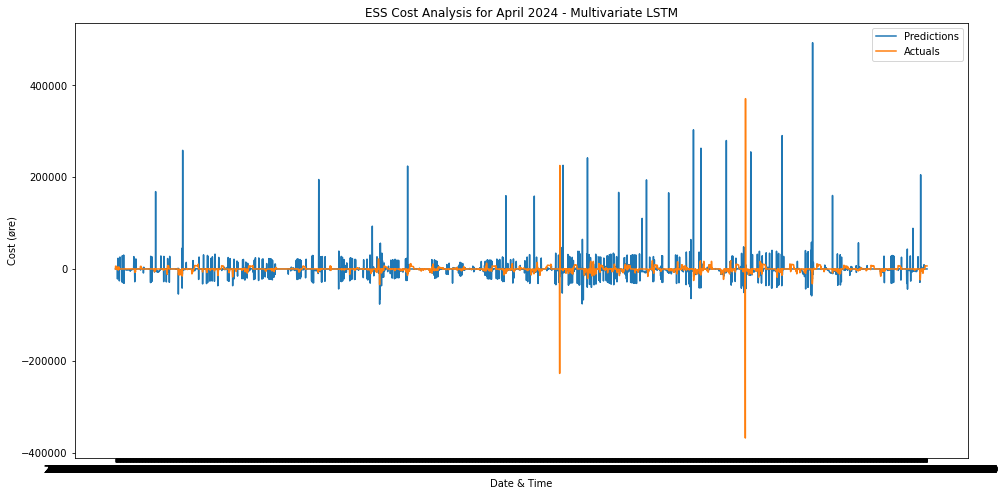

In [33]:
# Define the start and end indices for plotting
start = 0
end = len(battery_predictions)

# Set up the figure size for the plot
plt.figure(figsize=(16, 8))

# Plot the predicted battery cost over time
plt.plot(post_processed_dataframe['DateTime'][start:end], battery_predictions_price[start:end], label='Predictions')

# Plot the actual battery cost over time
plt.plot(post_processed_dataframe['DateTime'][start:end], battery_actuals_price[start:end], label='Actuals')

# Label the x-axis
plt.xlabel('Date & Time')

# Set the title of the plot
plt.title('ESS Cost Analysis for April 2024 - Multivariate LSTM')

# Label the y-axis
plt.ylabel('Cost (øre)')

# Display the legend to differentiate between predictions and actuals
plt.legend()

# Show the plot
plt.show()


In [34]:
print(str(battery_predictions_price.sum()/100), " NOK")

-479.56509597539787  NOK


In [35]:
print(str(battery_actuals_price.sum()/100)," NOK")

-1767.4674874999992  NOK


References

[1] Hogg, G., 2021. Multivariate Time Series Forecasting Using LSTM, GRU & 1d CNNs [video]. Available at: https://www.youtube.com/watch?v=kGdbPnMCdOg&t=2857s (Accessed: 15 June 2024).